In [1]:
# For 60:40 (actives:inactives) split in training and 50:50 (actives:inactives) in test datasets

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("train_dataset.csv", low_memory=False)

print(df.head())

                    Name  nAcid   ALogP    ALogp2       AMR       apol  \
0  AUTOGEN_molecule_1055      0 -0.1675  0.028056   27.2817  63.519481   
1  AUTOGEN_molecule_1553      1  0.2014  0.040562   65.1702  49.409067   
2  AUTOGEN_molecule_1419      1 -1.2467  1.554261   58.9439  48.185274   
3   AUTOGEN_molecule_864      0 -0.0762  0.005806  140.5798  70.599446   
4  AUTOGEN_molecule_1405      0  0.2097  0.043974   32.2568  58.831067   

   naAromAtom  nAromBond  nAtom  nHeavyAtom  ...     WTPT-4     WTPT-5  \
0          24         26     49          32  ...   5.642736  11.914899   
1           6          6     44          25  ...   7.426529   9.867435   
2           6          6     42          24  ...   7.434296   9.945672   
3           0          0     58          36  ...  14.676953  11.811918   
4          23         26     47          28  ...   3.074987  16.199478   

    WPATH  WPOL  XLogP  Zagreb  Molecular Weight  \
0  3272.0  52.0  6.208   174.0            400.31   
1  136

In [3]:
import numpy as np
import pandas as pd

# Drop non-numeric columns before correlation calculation
df_numeric = df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Compute correlation matrix
correlation_matrix = df_numeric.corr().abs()

# Identify highly correlated features (threshold = 0.9)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
df = df.drop(columns=to_drop, errors="ignore")

print(f"Removed {len(to_drop)} highly correlated features.")
print(f"Remaining features: {df.shape[1]}")


Removed 608 highly correlated features.
Remaining features: 297


/opt/conda/envs/openmm-env/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_142839/1161880113.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  mean_diff = abs(np.mean(class_values[0]) - np.mean(class_values[1]))
/tmp/ipykernel_142839/1161880113.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fw_ranked.values[:20], y=fw_ranked.index[:20], palette="viridis")  # Top 20 features


Top 20 features by Fisher Weight:
 AATSC6c     44.947641
AATSC7c     13.111723
AATSC6e      9.912864
AATSC8c      9.871975
VC-6         5.614301
AATSC7p      2.482371
AATSC6p      1.885118
SCH-3        1.218106
MATS3m       1.140568
n7Ring       1.013393
C2SP1        1.005917
SC-4         0.950987
MATS4m       0.906513
MATS6m       0.811740
MATS2e       0.778336
nsI          0.721868
MATS3s       0.696189
SC-6         0.589576
maxsssCH     0.588612
AATSC8e      0.569182
dtype: float64


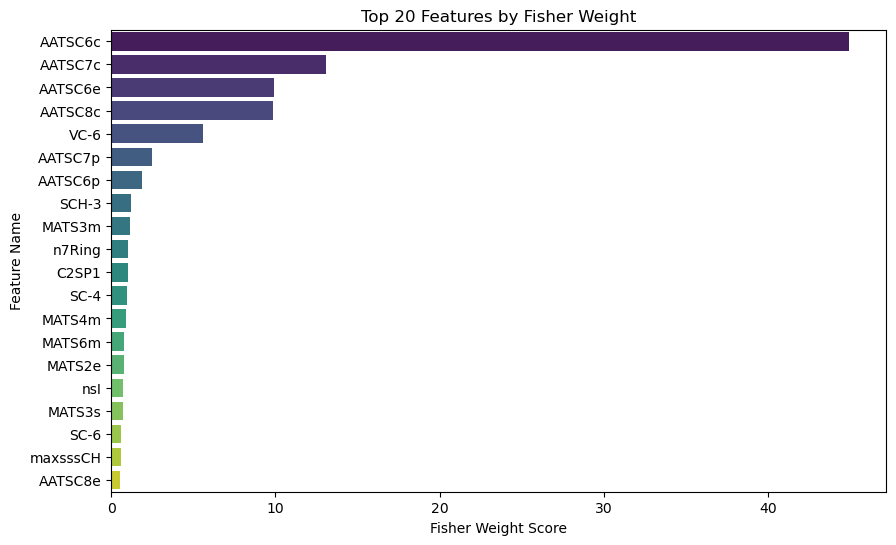

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler

def fisher_weight(X, y):
    """
    Compute Fisher Weights for each feature.

    Parameters:
    - X: DataFrame of features (only numeric values)
    - y: Target variable (binary classification)

    Returns:
    - A sorted Pandas Series with feature names as index and FW scores as values.
    """
    fw_scores = {}

    # Iterate over each feature column
    for feature in X.columns:
        # Get values for each class
        class_values = [X[feature][y == cls] for cls in np.unique(y)]

        # Fisher Weight formula: (mean difference squared) / (sum of variances)
        if len(class_values) == 2:  # Ensure only two classes
            mean_diff = abs(np.mean(class_values[0]) - np.mean(class_values[1]))
            variance_sum = np.var(class_values[0]) + np.var(class_values[1])

            fw_scores[feature] = mean_diff / variance_sum if variance_sum != 0 else 0
        else:
            fw_scores[feature] = 0  # If more than two classes, set score to 0

    # Convert to Pandas Series & sort by importance
    return pd.Series(fw_scores).sort_values(ascending=False)

# Ensure correct feature & target selection
X = df.select_dtypes(include=[np.number]).drop(columns=["Name", "Smiles"], errors="ignore")
y = df["Activity_Label"]  # Change to the correct column name

# Compute Fisher Weights
fw_ranked = fisher_weight(X, y)

# Display top features
print("Top 20 features by Fisher Weight:\n", fw_ranked.head(20))

# Save results to CSV
fw_ranked.to_csv("feature_importance_fw_ranking.csv")

# Plot Fisher Weight Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=fw_ranked.values[:20], y=fw_ranked.index[:20], palette="viridis")  # Top 20 features
plt.xlabel("Fisher Weight Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Features by Fisher Weight")
plt.show()

plt.savefig("FW_Feature_Importance.png", dpi=300, bbox_inches="tight")  
plt.show()

/opt/conda/envs/openmm-env/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/envs/openmm-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/openmm-env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count


Top 20 Important Features:
               Feature  Importance
293            MIC_µM    0.411695
292  Molecular Weight    0.029291
121            GATS5e    0.006746
107            GATS5c    0.006437
37             ATSC4v    0.006325
148       CrippenLogP    0.005032
29             ATSC4m    0.004974
52             ATSC7p    0.004800
67             ATSC7s    0.004754
99             MATS2e    0.004718
61             ATSC8i    0.004597
51             ATSC5p    0.004583
123            GATS7e    0.004478
36             ATSC3v    0.004472
22             ATSC5c    0.004458
43             ATSC2e    0.004334
103            MATS4s    0.004314
21             ATSC4c    0.004281
44             ATSC3e    0.004236
33             ATSC8m    0.004233


/tmp/ipykernel_142839/515696178.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"][:20], y=feature_importance_df["Feature"][:20], palette="viridis")  # Top 20 features


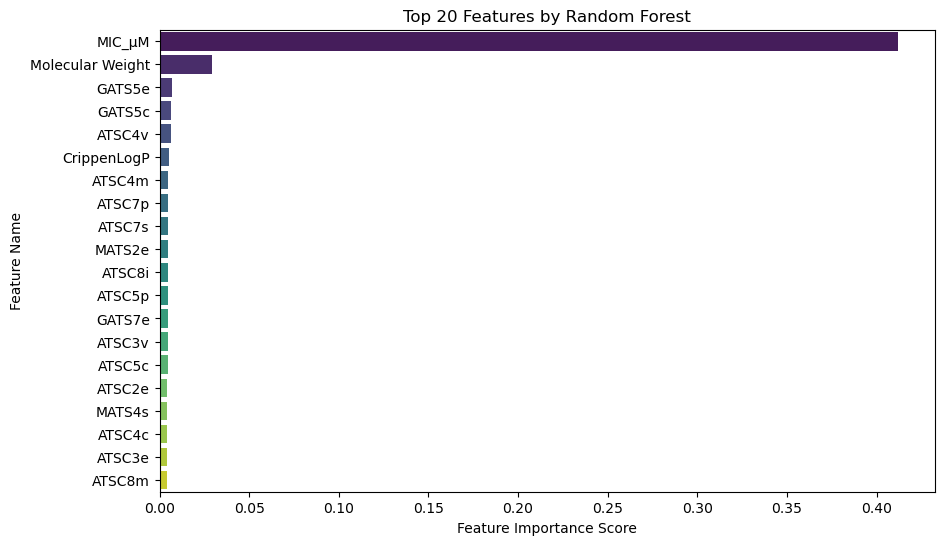

<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = df.drop(columns=["Activity_Label"])  # Features (molecular descriptors)
y = df["Activity_Label"]  # Target labels

# *Ensure only numeric features*
X = X.select_dtypes(include=[np.number])  # Drop non-numeric columns

# Handle missing and infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

# Scale features (Optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to retain feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled_df, y)

# Get feature importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X_scaled_df.columns,  
    "Importance": rf.feature_importances_
})

# Sort and display top features
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Save results to CSV
feature_importance_df.to_csv("feature_importance_rf_ranking.csv")

print("Top 20 Important Features:\n", feature_importance_df.head(20))

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"][:20], y=feature_importance_df["Feature"][:20], palette="viridis")  # Top 20 features
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Features by Random Forest")
plt.show()

plt.savefig("RF_Feature_Importance.png", dpi=300, bbox_inches="tight")  
plt.show()

In [6]:
import numpy as np

# Check for NaN values
print("NaN values in X:", np.isnan(X).sum().sum())

# Check for infinite values
print("Infinite values in X:", np.isinf(X).sum().sum())

# Check for extremely large values
print("Max value in X:", np.max(X.to_numpy()))
print("Min value in X:", np.min(X.to_numpy()))


NaN values in X: 0
Infinite values in X: 0
Max value in X: 1.7976931348623157e+308
Min value in X: -6635.678817464773



Weighted Random Forest Feature Importance:
MIC_µM              0.085940
Molecular Weight    0.056083
GATS5e              0.012990
GATS5c              0.011999
AATSC7p             0.010980
ATSC4v              0.010381
ATSC5v              0.009674
CrippenLogP         0.009445
ATSC5e              0.008985
ATSC7p              0.008530
ATSC3v              0.008062
ATSC6c              0.007867
AATSC6m             0.007721
MATS4m              0.007699
ATSC2e              0.007692
ATSC5c              0.007626
AATSC4m             0.007307
AATSC6e             0.007246
ATSC8s              0.006883
maxwHBa             0.006850
dtype: float64


/tmp/ipykernel_142839/2742717532.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"][:20], y=feature_importance_df["Feature"][:20], palette="viridis")  # Top 20 features


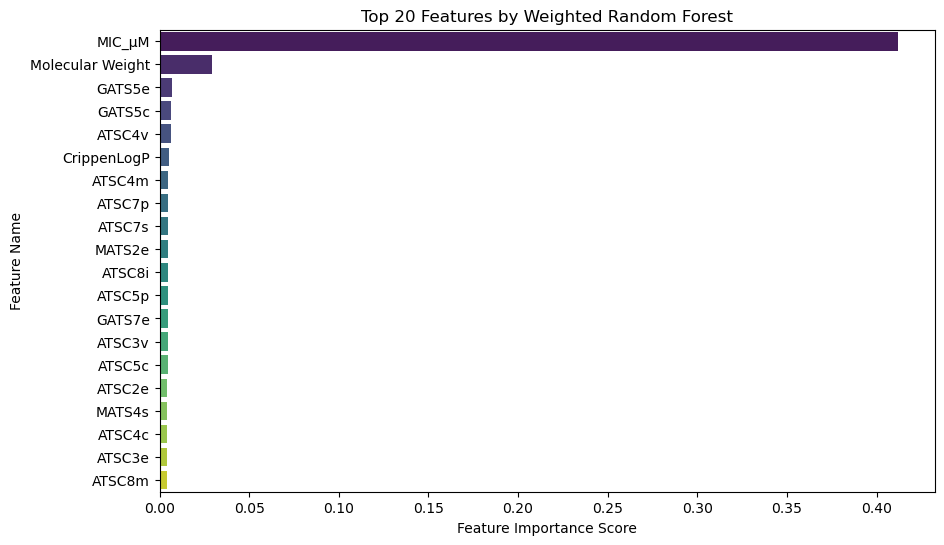

<Figure size 640x480 with 0 Axes>

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree

# Preprocess X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()  # or X.fillna(X.mean())
X = X.clip(-1e6, 1e6)  # Limit extreme values

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Define level weights: higher levels get more weight
level_weights = {0: 1.0, 1: 0.5, 2: 0.25, 3: 0.125}  # Default beyond level 3: 0.1

# Function to compute weighted feature importance
def get_feature_importance_wrf(model, X):
    feature_importance = {col: 0 for col in X.columns}

    for tree in model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            feature_index = tree_.feature[node]
            if feature_index == -2:  # Skip leaf nodes
                continue
            
            feature_name = X.columns[feature_index]
            depth = get_node_depth(tree_, node)
            weight = level_weights.get(depth, 0.1)  # Default weight = 0.1 for deeper levels

            # Accumulate weighted importance
            feature_importance[feature_name] += tree_.impurity[node] * weight

    # Normalize importance values
    total_importance = sum(feature_importance.values())
    feature_importance = {k: v / total_importance for k, v in feature_importance.items()}

    return pd.Series(feature_importance).sort_values(ascending=False)

# Optimized function to compute node depth
def get_node_depth(tree_, node):
    depth = 0
    while node != 0:
        parent = np.where(tree_.children_left == node)[0]
        if parent.size == 0:
            parent = np.where(tree_.children_right == node)[0]
        if parent.size == 0:
            break  # No parent found, avoid infinite loop
        node = parent[0]
        depth += 1
    return depth

# Compute weighted Random Forest importance
wRF_importance = get_feature_importance_wrf(rf, X)

# Print top-ranked features
print("\nWeighted Random Forest Feature Importance:")
print(wRF_importance.head(20))  # Show top 20 features

# Save results to CSV
wRF_importance.to_csv("feature_importance_wRF_ranking.csv")

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"][:20], y=feature_importance_df["Feature"][:20], palette="viridis")  # Top 20 features
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Features by Weighted Random Forest")
plt.show()

plt.savefig("wRF_Feature_Importance.png", dpi=300, bbox_inches="tight")  
plt.show()

/tmp/ipykernel_142839/2115401190.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pca_ranking[:20], y=pca_ranking.index[:20], palette="viridis")


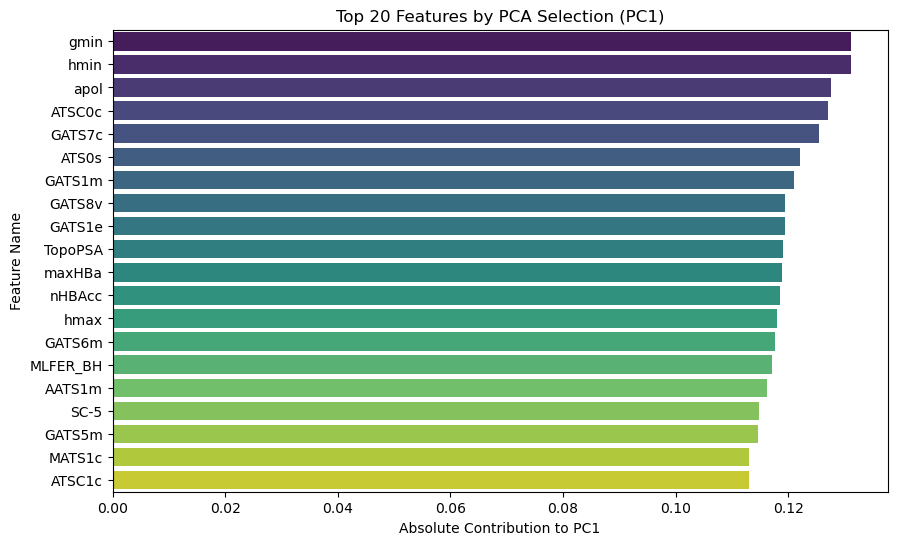

Top 20 PCA Selected Features (PC1 Only):
 gmin        0.131051
hmin        0.131051
apol        0.127629
ATSC0c      0.127106
GATS7c      0.125358
ATS0s       0.122082
GATS1m      0.120965
GATS8v      0.119346
GATS1e      0.119337
TopoPSA     0.119068
maxHBa      0.118939
nHBAcc      0.118453
hmax        0.117977
GATS6m      0.117622
MLFER_BH    0.117048
AATS1m      0.116251
SC-5        0.114748
GATS5m      0.114573
MATS1c      0.113052
ATSC1c      0.113011
Name: PC1, dtype: float64


<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Preprocess the Data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()  # or X.fillna(X.mean())
X = X.clip(-1e6, 1e6)  # Limit extreme values

# Step 2: Standardize the Features (PCA requires mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (Keep 2 Principal Components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Compute Feature Contributions (PC1)
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2'])
pca_ranking = pca_loadings["PC1"].abs().sort_values(ascending=False)  # Ranking based on PC1

# Step 5: Save PCA Feature Rankings
pca_ranking.to_csv("feature_importance_pca_ranking.csv")

# Step 6: Plot Top 20 PCA Selected Features
plt.figure(figsize=(10, 6))
sns.barplot(x=pca_ranking[:20], y=pca_ranking.index[:20], palette="viridis")
plt.xlabel("Absolute Contribution to PC1")
plt.ylabel("Feature Name")
plt.title("Top 20 Features by PCA Selection (PC1)")
plt.show()

# Step 7: Display Results
print("Top 20 PCA Selected Features (PC1 Only):\n", pca_ranking.head(20))

plt.savefig("PCA_Feature_Importance.png", dpi=300, bbox_inches="tight")  
plt.show()

/tmp/ipykernel_142839/3288082943.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wpca_ranking[:20], y=wpca_ranking.index[:20], palette="viridis")


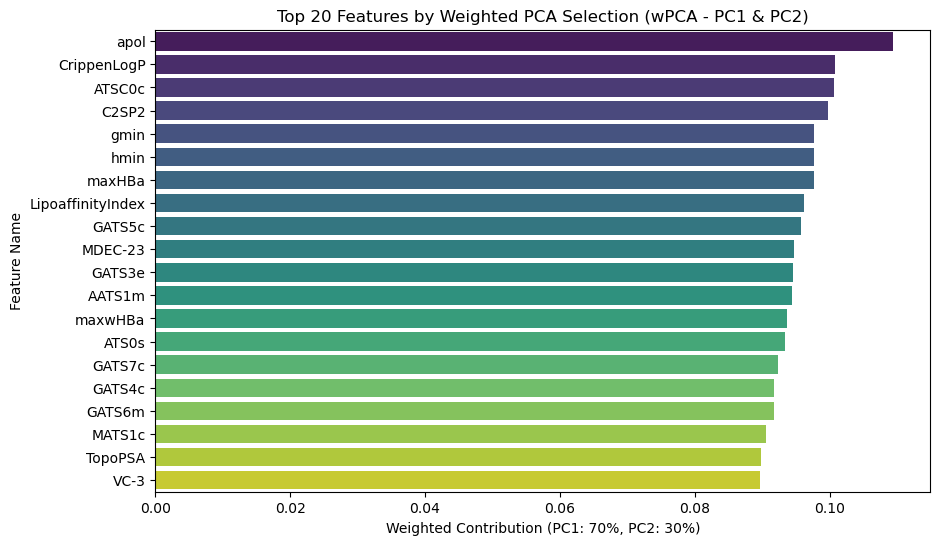

Top 20 Weighted PCA Selected Features (wPCA - PC1 & PC2):
 apol                 0.109465
CrippenLogP          0.100873
ATSC0c               0.100714
C2SP2                0.099833
gmin                 0.097755
hmin                 0.097754
maxHBa               0.097669
LipoaffinityIndex    0.096178
GATS5c               0.095695
MDEC-23              0.094658
GATS3e               0.094597
AATS1m               0.094483
maxwHBa              0.093647
ATS0s                0.093446
GATS7c               0.092359
GATS4c               0.091816
GATS6m               0.091768
MATS1c               0.090616
TopoPSA              0.089766
VC-3                 0.089704
dtype: float64


<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Preprocess the Data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()  # or X.fillna(X.mean())
X = X.clip(-1e6, 1e6)  # Limit extreme values

# Step 2: Standardize the Features (PCA requires mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (Keep 2 Principal Components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Compute Feature Contributions (Weighted PC1 & PC2)
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2'])
wpca_ranking = (pca_loadings["PC1"].abs() * 0.7 + pca_loadings["PC2"].abs() * 0.3).sort_values(ascending=False)

# Step 5: Save wPCA Feature Rankings
wpca_ranking.to_csv("feature_importance_wpca_ranking.csv")

# Step 6: Plot Top 20 wPCA Selected Features
plt.figure(figsize=(10, 6))
sns.barplot(x=wpca_ranking[:20], y=wpca_ranking.index[:20], palette="viridis")
plt.xlabel("Weighted Contribution (PC1: 70%, PC2: 30%)")
plt.ylabel("Feature Name")
plt.title("Top 20 Features by Weighted PCA Selection (wPCA - PC1 & PC2)")
plt.show()

# Step 7: Display Results
print("Top 20 Weighted PCA Selected Features (wPCA - PC1 & PC2):\n", wpca_ranking.head(20))

plt.savefig("wPCA_Feature_Importance.png", dpi=300, bbox_inches="tight")  
plt.show()

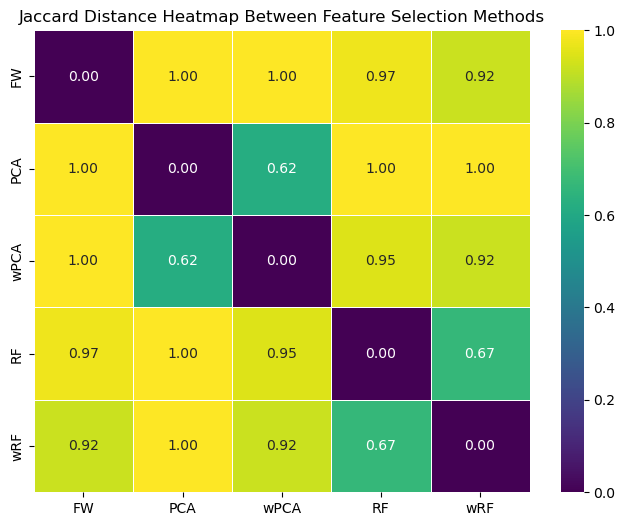

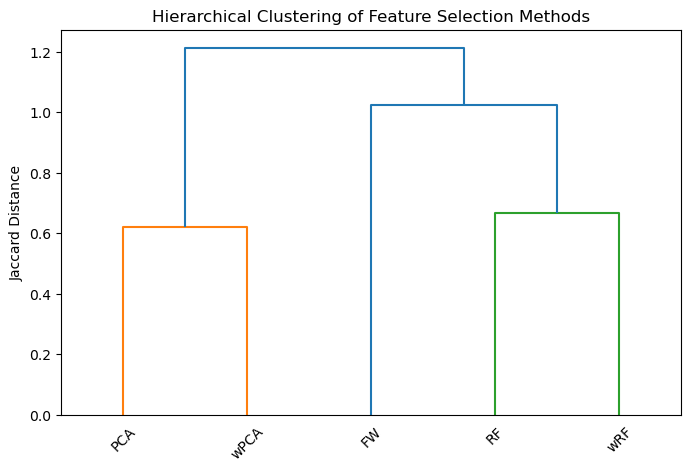

In [10]:
from sklearn.metrics import jaccard_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Load actual feature selection results (top 20 features from each method)
feature_sets = {
    "FW": set(fw_ranked.index[:20]),  # Fisher Weight
    "PCA": set(pca_ranking.index[:20]),  # PCA Selection
    "wPCA": set(wpca_ranking.index[:20]),  # Weighted PCA
    "RF": set(feature_importance_df["Feature"][:20]),  # Random Forest
    "wRF": set(wRF_importance.index[:20])  # Weighted Random Forest
}

# Get all unique descriptors across methods
all_features = set().union(*feature_sets.values())

# Convert feature sets into binary arrays (1 if feature exists, 0 otherwise)
binary_vectors = {
    method: np.array([1 if feature in selected_features else 0 for feature in all_features])
    for method, selected_features in feature_sets.items()
}

# Compute Jaccard distance matrix
methods = list(feature_sets.keys())
num_methods = len(methods)
jaccard_matrix = np.zeros((num_methods, num_methods))

for i in range(num_methods):
    for j in range(num_methods):
        if i != j:
            jaccard_matrix[i, j] = 1 - jaccard_score(binary_vectors[methods[i]], binary_vectors[methods[j]])

# Convert to Pandas DataFrame for visualization
df_jaccard = pd.DataFrame(jaccard_matrix, index=methods, columns=methods)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_jaccard, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Jaccard Distance Heatmap Between Feature Selection Methods")
plt.savefig("jaccard_distance_heatmap.png", dpi=300)  # Save figure
plt.show()

# Convert the square Jaccard matrix into a condensed form
jaccard_condensed = squareform(jaccard_matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(jaccard_condensed, method='ward')

# Plot dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels=methods, leaf_rotation=45, leaf_font_size=10)
plt.title("Hierarchical Clustering of Feature Selection Methods")
plt.ylabel("Jaccard Distance")
plt.savefig("jaccard_distance_dendrogram.png", dpi=300)  # Save figure
plt.show()


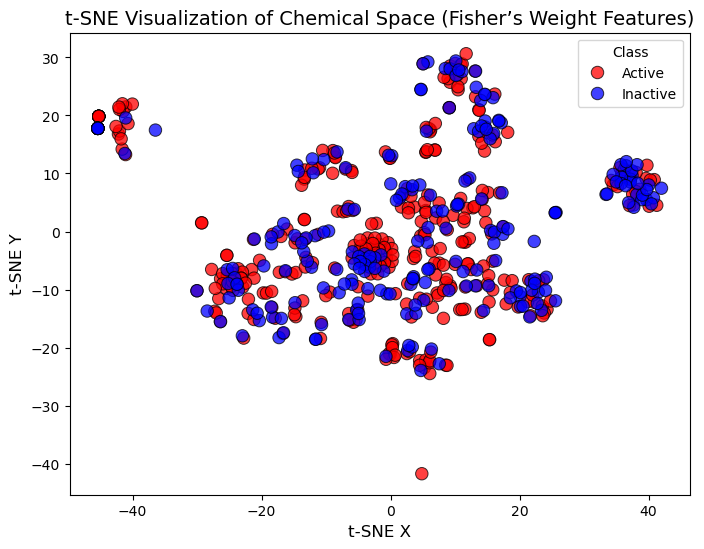

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Ensure selected features are numeric (Fisher Weights top 20)
selected_features = fw_ranked.index[:20]  # Take top 20 Fisher Weight features
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Activity_Label' column.")

y = df["Activity_Label"].copy()  # Target labels (Active/Inactive)

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform t-SNE with optimized parameters
tsne = TSNE(n_components=2, perplexity=min(30, len(X_scaled) - 1), random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ Convert into DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Activity_Label"] = y  # Add mapped labels

# ✅ Define color mapping for classes (Auto-detect unique class values)
palette = {"Active": "red", "Inactive": "blue"}  # Custom colors

# ✅ Plot t-SNE scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TSNE-1", 
    y="TSNE-2", 
    hue="Activity_Label", 
    palette=palette,
    data=df_tsne,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("t-SNE Visualization of Chemical Space (Fisher’s Weight Features)", fontsize=14)
plt.xlabel("t-SNE X", fontsize=12)
plt.ylabel("t-SNE Y", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("tsne_fisher_weight.png", dpi=300, bbox_inches="tight")

plt.show()


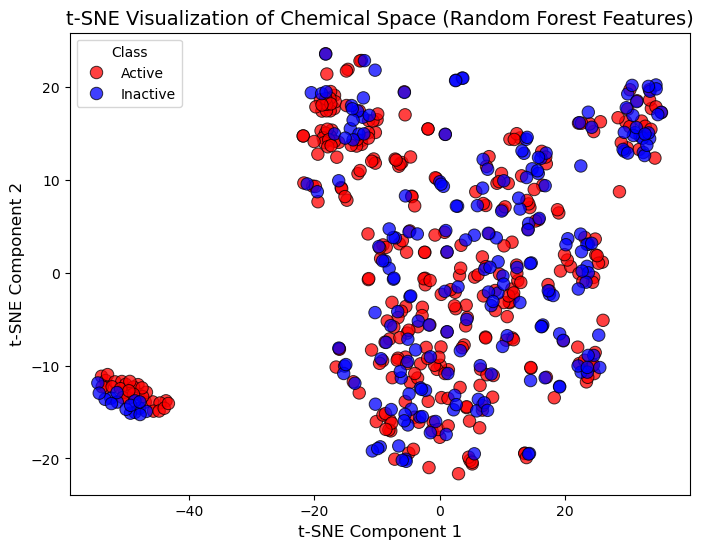

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Ensure selected features are numeric (Random Forest top 20)
selected_features = feature_importance_df["Feature"][:20]  # Take top 20 Random Forest features
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Activity_Label' column.")

y = df["Activity_Label"].copy()  # Target labels (Active/Inactive)

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform t-SNE with optimized parameters
tsne = TSNE(n_components=2, perplexity=min(30, len(X_scaled) - 1), random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ Convert into DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Activity_Label"] = y  # Add mapped labels

# ✅ Define color mapping for classes (Auto-detect unique class values)
palette = {"Active": "red", "Inactive": "blue"}  # Custom colors

# ✅ Plot t-SNE scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TSNE-1", 
    y="TSNE-2", 
    hue="Activity_Label", 
    palette=palette,
    data=df_tsne,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("t-SNE Visualization of Chemical Space (Random Forest Features)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("tsne_random_forest.png", dpi=300, bbox_inches="tight")

plt.show()


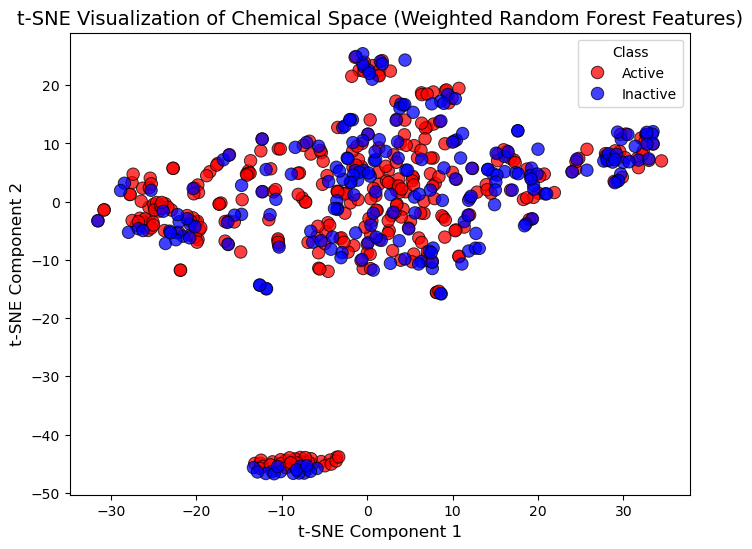

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Ensure selected features are numeric (wRF top 20)
selected_features = wRF_importance.index[:20]  # Take top 20 wRF features
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Activity_Label' column.")

y = df["Activity_Label"].copy()  # Target labels (Active/Inactive)

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform t-SNE with optimized parameters
tsne = TSNE(n_components=2, perplexity=min(30, len(X_scaled) - 1), random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ Convert into DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Activity_Label"] = y  # Add mapped labels

# ✅ Define color mapping for classes (Auto-detect unique class values)
palette = {"Active": "red", "Inactive": "blue"}  # Custom colors

# ✅ Plot t-SNE scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TSNE-1", 
    y="TSNE-2", 
    hue="Activity_Label", 
    palette=palette,
    data=df_tsne,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("t-SNE Visualization of Chemical Space (Weighted Random Forest Features)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("tsne_weighted_random_forest.png", dpi=300, bbox_inches="tight")

plt.show()


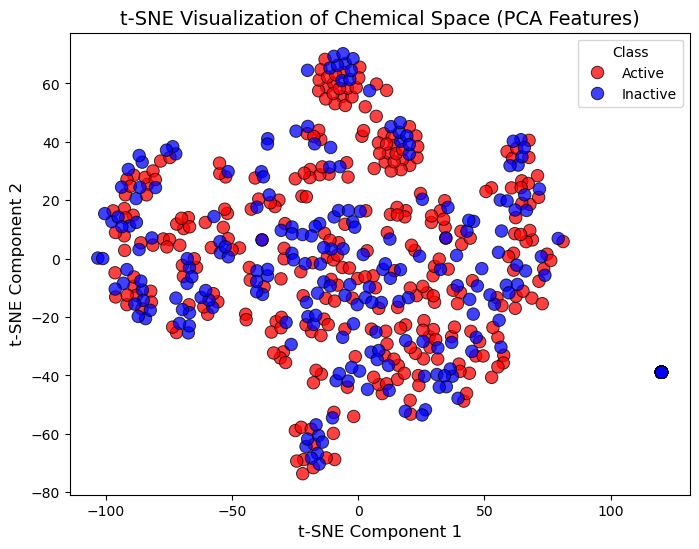

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Ensure selected features are numeric (PCA top 20)
selected_features = pca_ranking.index[:20]  # Take top 20 PCA features
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Activity_Label' column.")

y = df["Activity_Label"].copy()  # Target labels (Active/Inactive)

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize features
# Step 1: Preprocess the Data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()  # or X.fillna(X.mean())
X = X.clip(-1e6, 1e6)  # Limit extreme values

# Step 2: Standardize the Features (PCA requires mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform t-SNE with optimized parameters
tsne = TSNE(n_components=2, perplexity=min(30, len(X_scaled) - 1), random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ Convert into DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Activity_Label"] = y  # Add mapped labels

# ✅ Define color mapping for classes (Auto-detect unique class values)
palette = {"Active": "red", "Inactive": "blue"}  # Custom colors

# ✅ Plot t-SNE scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TSNE-1", 
    y="TSNE-2", 
    hue="Activity_Label", 
    palette=palette,
    data=df_tsne,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("t-SNE Visualization of Chemical Space (PCA Features)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("tsne_PCA.png", dpi=300, bbox_inches="tight")

plt.show()


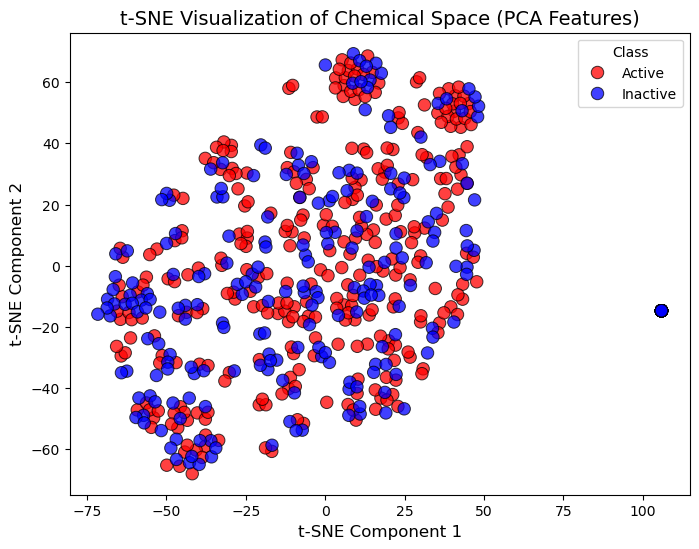

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Ensure selected features are numeric (wPCA top 20)
selected_features = wpca_ranking.index[:20]  # Take top 20 wPCA features
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Activity_Label' column.")

y = df["Activity_Label"].copy()  # Target labels (Active/Inactive)

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize features
# Step 1: Preprocess the Data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()  # or X.fillna(X.mean())
X = X.clip(-1e6, 1e6)  # Limit extreme values

# Step 2: Standardize the Features (PCA requires mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform t-SNE with optimized parameters
tsne = TSNE(n_components=2, perplexity=min(30, len(X_scaled) - 1), random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ Convert into DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Activity_Label"] = y  # Add mapped labels

# ✅ Define color mapping for classes (Auto-detect unique class values)
palette = {"Active": "red", "Inactive": "blue"}  # Custom colors

# ✅ Plot t-SNE scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TSNE-1", 
    y="TSNE-2", 
    hue="Activity_Label", 
    palette=palette,
    data=df_tsne,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("t-SNE Visualization of Chemical Space (PCA Features)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("tsne_weighted_PCA.png", dpi=300, bbox_inches="tight")

plt.show()


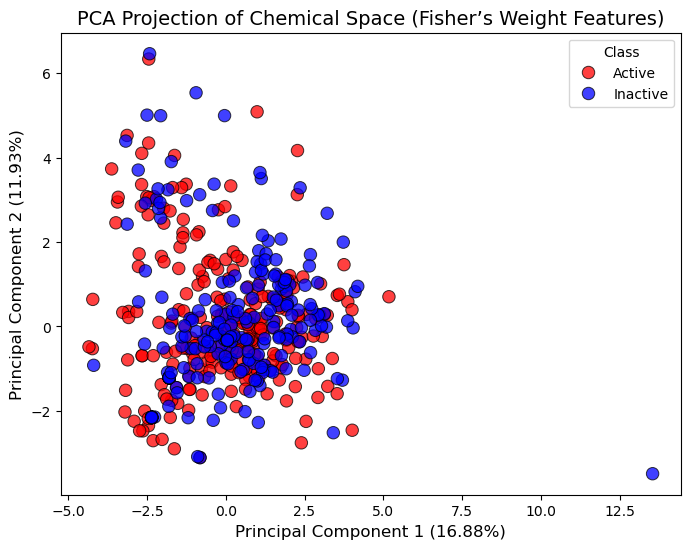

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ✅ Load dataset
df = pd.read_csv("train_dataset.csv")

# ✅ Select top 20 Fisher Weight features
selected_features = fw_ranked.index[:20]  # Top 20 features based on Fisher Weight
X = df[selected_features].select_dtypes(include=[np.number]).copy()

# ✅ Ensure class column exists
if "Activity_Label" not in df.columns:
    raise ValueError("The dataset must contain a 'Class' column.")

y = df["Activity_Label"].copy()  # Target labels

# ✅ Convert numeric class labels (0 → "Inactive", 1 → "Active")
y = y.replace({0: "Inactive", 1: "Active"})

# ✅ Normalize feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Perform PCA (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ✅ Convert to DataFrame
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Activity_Label"] = y  # Add class labels

# ✅ Define color mapping
palette = {"Active": "red", "Inactive": "blue"}

# ✅ Plot PCA scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Activity_Label",
    palette=palette,
    data=df_pca,
    s=80,  # Larger points
    edgecolor="black",
    alpha=0.75
)

# ✅ Improve readability
plt.title("PCA Projection of Chemical Space (Fisher’s Weight Features)", fontsize=14)
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.legend(title="Class", fontsize=10)

# ✅ Save figure
plt.savefig("pca_fisher_weight.png", dpi=300, bbox_inches="tight")

plt.show()
